In [55]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import mlflow

In [56]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db


env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [57]:
mlflow.sklearn.autolog()

2024/01/24 20:27:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [58]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [59]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

with mlflow.start_run(run_name='linear regression-1'):
    mlflow.set_tag('model', 'linear regression-1')
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)

    rmse= mean_squared_error(y_train, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

2024/01/24 20:27:34 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


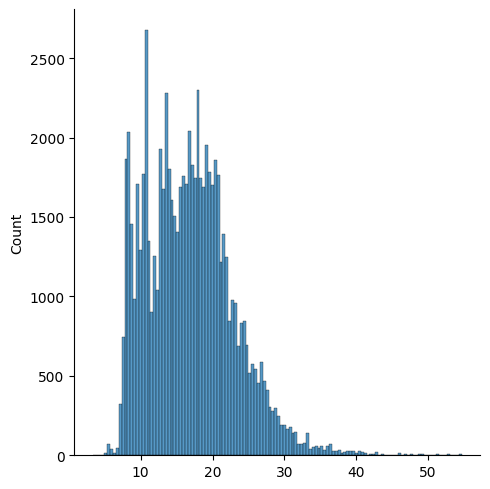

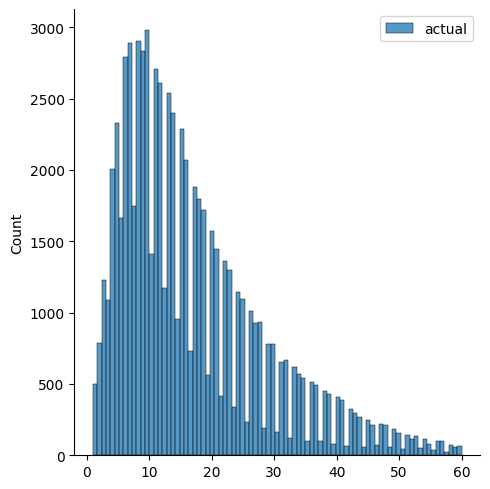

In [60]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()


In [61]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [62]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [63]:
len(df_train), len(df_val)

(73908, 61921)

In [64]:

df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [65]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [66]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [67]:
with mlflow.start_run(run_name='linear regression-2'):
    mlflow.set_tag('model', 'baseline')
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse= mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse) 


2024/01/24 20:27:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [68]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [69]:
with mlflow.start_run(run_name='lasso'):
    mlflow.set_tag('model', 'lasso')
    alpha = 0.01
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse= mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse) 

2024/01/24 20:27:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72439                          
[1]	validation-rmse:11.27392                          
[2]	validation-rmse:10.85936                          
[3]	validation-rmse:10.47863                          
[4]	validation-rmse:10.12925                          
[5]	validation-rmse:9.80925                           
[6]	validation-rmse:9.51655                           
[7]	validation-rmse:9.24851                           
[8]	validation-rmse:9.00383                           
[9]	validation-rmse:8.78098                           
[10]	validation-rmse:8.57777                          
[11]	validation-rmse:8.39360                          
[12]	validation-rmse:8.22587                          
[13]	validation-rmse:8.07358                          
[14]	validation-rmse:7.93592                          
[15]	validation-rmse:7.81178                          
[16]	validation-rmse:7.69892                          
[17]	validation-rmse:7.59714                          
[18]	valid

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



  2%|▏         | 1/50 [00:28<23:35, 28.88s/trial, best loss: 6.561041572092504]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:31:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35585                                                   
[1]	validation-rmse:10.61535                                                   
[2]	validation-rmse:9.97832                                                    
[3]	validation-rmse:9.43350                                                    
[4]	validation-rmse:8.96960                                                    
[5]	validation-rmse:8.57626                                                    
[6]	validation-rmse:8.24352                                                    
[7]	validation-rmse:7.96291                                                    
[8]	validation-rmse:7.72766                                                    
[9]	validation-rmse:7.53091                                                    
[10]	validation-rmse:7.36698                                                   
[11]	validation-rmse:7.23055                                                   
[12]	validation-rmse:7.11542            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:32:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.90333                                                    
[1]	validation-rmse:8.52430                                                    
[2]	validation-rmse:7.73722                                                    
[3]	validation-rmse:7.29611                                                    
[4]	validation-rmse:7.05369                                                    
[5]	validation-rmse:6.91487                                                    
[6]	validation-rmse:6.83283                                                    
[7]	validation-rmse:6.78385                                                    
[8]	validation-rmse:6.75437                                                    
[9]	validation-rmse:6.73349                                                    
[10]	validation-rmse:6.72075                                                   
[11]	validation-rmse:6.71022                                                   
[12]	validation-rmse:6.70359            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:32:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.19762                                                    
[1]	validation-rmse:7.71303                                                    
[2]	validation-rmse:7.03419                                                    
[3]	validation-rmse:6.72443                                                    
[4]	validation-rmse:6.58670                                                    
[5]	validation-rmse:6.51597                                                    
[6]	validation-rmse:6.47371                                                    
[7]	validation-rmse:6.45008                                                    
[8]	validation-rmse:6.43483                                                    
[9]	validation-rmse:6.42095                                                    
[10]	validation-rmse:6.41514                                                   
[11]	validation-rmse:6.41249                                                   
[12]	validation-rmse:6.41010            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:33:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.95011                                                    
[1]	validation-rmse:8.56465                                                    
[2]	validation-rmse:7.75296                                                    
[3]	validation-rmse:7.27544                                                    
[4]	validation-rmse:6.99627                                                    
[5]	validation-rmse:6.83230                                                    
[6]	validation-rmse:6.73672                                                    
[7]	validation-rmse:6.67573                                                    
[8]	validation-rmse:6.63995                                                    
[9]	validation-rmse:6.61337                                                    
[10]	validation-rmse:6.59552                                                   
[11]	validation-rmse:6.57985                                                   
[12]	validation-rmse:6.56959            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:34:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38475                                                   
[1]	validation-rmse:10.66753                                                   
[2]	validation-rmse:10.04927                                                   
[3]	validation-rmse:9.51842                                                    
[4]	validation-rmse:9.06415                                                    
[5]	validation-rmse:8.67740                                                    
[6]	validation-rmse:8.34969                                                    
[7]	validation-rmse:8.07279                                                    
[8]	validation-rmse:7.84058                                                    
[9]	validation-rmse:7.64415                                                    
[10]	validation-rmse:7.47953                                                   
[11]	validation-rmse:7.34065                                                   
[12]	validation-rmse:7.22414            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:34:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.57667                                                   
[1]	validation-rmse:9.39028                                                    
[2]	validation-rmse:8.54506                                                    
[3]	validation-rmse:7.95837                                                    
[4]	validation-rmse:7.54811                                                    
[5]	validation-rmse:7.26873                                                    
[6]	validation-rmse:7.07758                                                    
[7]	validation-rmse:6.94642                                                    
[8]	validation-rmse:6.85420                                                    
[9]	validation-rmse:6.78894                                                    
[10]	validation-rmse:6.74018                                                   
[11]	validation-rmse:6.70547                                                   
[12]	validation-rmse:6.68050            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:34:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40224                                                   
[1]	validation-rmse:10.69970                                                   
[2]	validation-rmse:10.09350                                                   
[3]	validation-rmse:9.57244                                                    
[4]	validation-rmse:9.12676                                                    
[5]	validation-rmse:8.74713                                                    
[6]	validation-rmse:8.42478                                                    
[7]	validation-rmse:8.15203                                                    
[8]	validation-rmse:7.92256                                                    
[9]	validation-rmse:7.72883                                                    
[10]	validation-rmse:7.56625                                                   
[11]	validation-rmse:7.42922                                                   
[12]	validation-rmse:7.31435            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:35:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.93962                                                    
[1]	validation-rmse:8.52416                                                    
[2]	validation-rmse:7.67521                                                    
[3]	validation-rmse:7.17914                                                    
[4]	validation-rmse:6.89151                                                    
[5]	validation-rmse:6.72048                                                    
[6]	validation-rmse:6.62298                                                    
[7]	validation-rmse:6.56039                                                    
[8]	validation-rmse:6.51695                                                    
[9]	validation-rmse:6.48910                                                    
[10]	validation-rmse:6.46963                                                   
[11]	validation-rmse:6.45478                                                   
[12]	validation-rmse:6.44394            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 18%|█▊        | 9/50 [05:33<24:42, 36.16s/trial, best loss: 6.341035110912578]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99143                                                    
[1]	validation-rmse:8.62535                                                    
[2]	validation-rmse:7.81497                                                    
[3]	validation-rmse:7.34223                                                    
[4]	validation-rmse:7.06789                                                    
[5]	validation-rmse:6.91235                                                    
[6]	validation-rmse:6.81513                                                    
[7]	validation-rmse:6.75775                                                    
[8]	validation-rmse:6.72249                                                    
[9]	validation-rmse:6.69988                                                    
[10]	validation-rmse:6.68419                                                   
[11]	validation-rmse:6.67281                                                   
[12]	validation-rmse:6.66401            

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 10/50 [05:43<18:53, 28.33s/trial, best loss: 6.341035110912578]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.00703                                                    
[1]	validation-rmse:10.04116                                                    
[2]	validation-rmse:9.27512                                                     
[3]	validation-rmse:8.67168                                                     
[4]	validation-rmse:8.20232                                                     
[5]	validation-rmse:7.84024                                                     
[6]	validation-rmse:7.56216                                                     
[7]	validation-rmse:7.34701                                                     
[8]	validation-rmse:7.18301                                                     
[9]	validation-rmse:7.05673                                                     
[10]	validation-rmse:6.96057                                                    
[11]	validation-rmse:6.88497                                                    
[12]	validation-rmse:6.82555

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 22%|██▏       | 11/50 [05:56<15:12, 23.40s/trial, best loss: 6.341035110912578]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.40395                                                    
[1]	validation-rmse:9.15256                                                     
[2]	validation-rmse:8.30624                                                     
[3]	validation-rmse:7.74764                                                     
[4]	validation-rmse:7.38316                                                     
[5]	validation-rmse:7.14642                                                     
[6]	validation-rmse:6.99271                                                     
[7]	validation-rmse:6.88911                                                     
[8]	validation-rmse:6.81562                                                     
[9]	validation-rmse:6.76679                                                     
[10]	validation-rmse:6.73046                                                    
[11]	validation-rmse:6.70530                                                    
[12]	validation-rmse:6.68543

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.23979                                                    
[1]	validation-rmse:8.93701                                                     
[2]	validation-rmse:8.10433                                                     
[3]	validation-rmse:7.58459                                                     
[4]	validation-rmse:7.26355                                                     
[5]	validation-rmse:7.06545                                                     
[6]	validation-rmse:6.94338                                                     
[7]	validation-rmse:6.86541                                                     
[8]	validation-rmse:6.81354                                                     
[9]	validation-rmse:6.78030                                                     
[10]	validation-rmse:6.75741                                                    
[11]	validation-rmse:6.73983                                                    
[12]	validation-rmse:6.72740

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 26%|██▌       | 13/50 [06:23<10:57, 17.77s/trial, best loss: 6.341035110912578]

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:37:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.51920                                                    
[1]	validation-rmse:9.30861                                                     
[2]	validation-rmse:8.45966                                                     
[3]	validation-rmse:7.87397                                                     
[4]	validation-rmse:7.47118                                                     
[5]	validation-rmse:7.20277                                                     
[6]	validation-rmse:7.01519                                                     
[7]	validation-rmse:6.88967                                                     
[8]	validation-rmse:6.80328                                                     
[9]	validation-rmse:6.74008                                                     
[10]	validation-rmse:6.69540                                                    
[11]	validation-rmse:6.65815                                                    
[12]	validation-rmse:6.63367

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:37:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.44547                                                    
[1]	validation-rmse:9.20665                                                     
[2]	validation-rmse:8.35631                                                     
[3]	validation-rmse:7.78508                                                     
[4]	validation-rmse:7.40727                                                     
[5]	validation-rmse:7.15719                                                     
[6]	validation-rmse:6.99361                                                     
[7]	validation-rmse:6.87883                                                     
[8]	validation-rmse:6.80256                                                     
[9]	validation-rmse:6.74863                                                     
[10]	validation-rmse:6.71177                                                    
[11]	validation-rmse:6.68439                                                    
[12]	validation-rmse:6.66387

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:37:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01750                                                    
[1]	validation-rmse:10.06084                                                    
[2]	validation-rmse:9.30217                                                     
[3]	validation-rmse:8.70758                                                     
[4]	validation-rmse:8.24534                                                     
[5]	validation-rmse:7.88888                                                     
[6]	validation-rmse:7.61530                                                     
[7]	validation-rmse:7.40664                                                     
[8]	validation-rmse:7.24713                                                     
[9]	validation-rmse:7.12522                                                     
[10]	validation-rmse:7.03121                                                    
[11]	validation-rmse:6.95982                                                    
[12]	validation-rmse:6.90365

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:38:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.61680                                                    
[1]	validation-rmse:9.44899                                                     
[2]	validation-rmse:8.61345                                                     
[3]	validation-rmse:8.02210                                                     
[4]	validation-rmse:7.61041                                                     
[5]	validation-rmse:7.32383                                                     
[6]	validation-rmse:7.12803                                                     
[7]	validation-rmse:6.99062                                                     
[8]	validation-rmse:6.89300                                                     
[9]	validation-rmse:6.82591                                                     
[10]	validation-rmse:6.77689                                                    
[11]	validation-rmse:6.74115                                                    
[12]	validation-rmse:6.71452

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:38:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44056                                                    
[1]	validation-rmse:10.76781                                                    
[2]	validation-rmse:10.17779                                                    
[3]	validation-rmse:9.67128                                                     
[4]	validation-rmse:9.22637                                                     
[5]	validation-rmse:8.84890                                                     
[6]	validation-rmse:8.51791                                                     
[7]	validation-rmse:8.23611                                                     
[8]	validation-rmse:7.99639                                                     
[9]	validation-rmse:7.79065                                                     
[10]	validation-rmse:7.61748                                                    
[11]	validation-rmse:7.46757                                                    
[12]	validation-rmse:7.34250

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:39:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.05908                                                    
[1]	validation-rmse:10.12577                                                    
[2]	validation-rmse:9.37691                                                     
[3]	validation-rmse:8.78104                                                     
[4]	validation-rmse:8.31183                                                     
[5]	validation-rmse:7.94551                                                     
[6]	validation-rmse:7.66163                                                     
[7]	validation-rmse:7.43657                                                     
[8]	validation-rmse:7.26336                                                     
[9]	validation-rmse:7.12948                                                     
[10]	validation-rmse:7.02517                                                    
[11]	validation-rmse:6.94370                                                    
[12]	validation-rmse:6.87978

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:39:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98275                                                     
[1]	validation-rmse:7.57648                                                     
[2]	validation-rmse:7.01895                                                     
[3]	validation-rmse:6.78516                                                     
[4]	validation-rmse:6.67314                                                     
[5]	validation-rmse:6.62117                                                     
[6]	validation-rmse:6.59620                                                     
[7]	validation-rmse:6.57832                                                     
[8]	validation-rmse:6.56866                                                     
[9]	validation-rmse:6.55581                                                     
[10]	validation-rmse:6.55302                                                    
[11]	validation-rmse:6.54625                                                    
[12]	validation-rmse:6.54278

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:40:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.98348                                                     
[1]	validation-rmse:6.85497                                                     
[2]	validation-rmse:6.58811                                                     
[3]	validation-rmse:6.50104                                                     
[4]	validation-rmse:6.46744                                                     
[5]	validation-rmse:6.45652                                                     
[6]	validation-rmse:6.44610                                                     
[7]	validation-rmse:6.44035                                                     
[8]	validation-rmse:6.43636                                                     
[9]	validation-rmse:6.43073                                                     
[10]	validation-rmse:6.42839                                                    
[11]	validation-rmse:6.42360                                                    
[12]	validation-rmse:6.41792

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:40:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.85583                                                     
[1]	validation-rmse:6.74944                                                     
[2]	validation-rmse:6.72527                                                     
[3]	validation-rmse:6.71431                                                     
[4]	validation-rmse:6.71113                                                     
[5]	validation-rmse:6.70496                                                     
[6]	validation-rmse:6.68518                                                     
[7]	validation-rmse:6.67823                                                     
[8]	validation-rmse:6.67415                                                     
[9]	validation-rmse:6.67181                                                     
[10]	validation-rmse:6.66958                                                    
[11]	validation-rmse:6.67027                                                    
[12]	validation-rmse:6.66317

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:40:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.67569                                                     
[1]	validation-rmse:7.28588                                                     
[2]	validation-rmse:6.78807                                                     
[3]	validation-rmse:6.60070                                                     
[4]	validation-rmse:6.52297                                                     
[5]	validation-rmse:6.48450                                                     
[6]	validation-rmse:6.45850                                                     
[7]	validation-rmse:6.44910                                                     
[8]	validation-rmse:6.44124                                                     
[9]	validation-rmse:6.43639                                                     
[10]	validation-rmse:6.43253                                                    
[11]	validation-rmse:6.42696                                                    
[12]	validation-rmse:6.42298

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:41:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.07896                                                     
[1]	validation-rmse:6.92173                                                     
[2]	validation-rmse:6.61198                                                     
[3]	validation-rmse:6.52012                                                     
[4]	validation-rmse:6.48216                                                     
[5]	validation-rmse:6.46591                                                     
[6]	validation-rmse:6.45920                                                     
[7]	validation-rmse:6.45314                                                     
[8]	validation-rmse:6.44474                                                     
[9]	validation-rmse:6.43969                                                     
[10]	validation-rmse:6.43251                                                    
[11]	validation-rmse:6.42756                                                    
[12]	validation-rmse:6.42262

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:41:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.93733                                                     
[1]	validation-rmse:6.74850                                                     
[2]	validation-rmse:6.71701                                                     
[3]	validation-rmse:6.70628                                                     
[4]	validation-rmse:6.69994                                                     
[5]	validation-rmse:6.69468                                                     
[6]	validation-rmse:6.69061                                                     
[7]	validation-rmse:6.68711                                                     
[8]	validation-rmse:6.68488                                                     
[9]	validation-rmse:6.68290                                                     
[10]	validation-rmse:6.68379                                                    
[11]	validation-rmse:6.67895                                                    
[12]	validation-rmse:6.68117

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:41:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69437                                                     
[1]	validation-rmse:7.29675                                                     
[2]	validation-rmse:6.79024                                                     
[3]	validation-rmse:6.60081                                                     
[4]	validation-rmse:6.51543                                                     
[5]	validation-rmse:6.47726                                                     
[6]	validation-rmse:6.45183                                                     
[7]	validation-rmse:6.43830                                                     
[8]	validation-rmse:6.43339                                                     
[9]	validation-rmse:6.42619                                                     
[10]	validation-rmse:6.42141                                                    
[11]	validation-rmse:6.41873                                                    
[12]	validation-rmse:6.41485

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:42:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.29620                                                     
[1]	validation-rmse:6.64861                                                     
[2]	validation-rmse:6.53908                                                     
[3]	validation-rmse:6.50350                                                     
[4]	validation-rmse:6.49270                                                     
[5]	validation-rmse:6.47814                                                     
[6]	validation-rmse:6.47016                                                     
[7]	validation-rmse:6.46097                                                     
[8]	validation-rmse:6.45258                                                     
[9]	validation-rmse:6.44747                                                     
[10]	validation-rmse:6.44481                                                    
[11]	validation-rmse:6.43681                                                    
[12]	validation-rmse:6.43069

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:42:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.21794                                                     
[1]	validation-rmse:7.74145                                                     
[2]	validation-rmse:7.06167                                                     
[3]	validation-rmse:6.75391                                                     
[4]	validation-rmse:6.61229                                                     
[5]	validation-rmse:6.53772                                                     
[6]	validation-rmse:6.49702                                                     
[7]	validation-rmse:6.47164                                                     
[8]	validation-rmse:6.45663                                                     
[9]	validation-rmse:6.44521                                                     
[10]	validation-rmse:6.43931                                                    
[11]	validation-rmse:6.43276                                                    
[12]	validation-rmse:6.43006

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:43:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.35589                                                      
[1]	validation-rmse:7.91811                                                      
[2]	validation-rmse:7.23882                                                      
[3]	validation-rmse:6.89365                                                      
[4]	validation-rmse:6.74419                                                      
[5]	validation-rmse:6.65630                                                      
[6]	validation-rmse:6.60719                                                      
[7]	validation-rmse:6.57772                                                      
[8]	validation-rmse:6.55967                                                      
[9]	validation-rmse:6.54514                                                      
[10]	validation-rmse:6.53958                                                     
[11]	validation-rmse:6.53508                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:43:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.34628                                                      
[1]	validation-rmse:7.85853                                                      
[2]	validation-rmse:7.13764                                                      
[3]	validation-rmse:6.79252                                                      
[4]	validation-rmse:6.62827                                                      
[5]	validation-rmse:6.54364                                                      
[6]	validation-rmse:6.49235                                                      
[7]	validation-rmse:6.46339                                                      
[8]	validation-rmse:6.44698                                                      
[9]	validation-rmse:6.43416                                                      
[10]	validation-rmse:6.42677                                                     
[11]	validation-rmse:6.42161                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.41797                                                      
[1]	validation-rmse:6.78792                                                      
[2]	validation-rmse:6.68593                                                      
[3]	validation-rmse:6.65886                                                      
[4]	validation-rmse:6.65046                                                      
[5]	validation-rmse:6.64166                                                      
[6]	validation-rmse:6.64057                                                      
[7]	validation-rmse:6.63319                                                      
[8]	validation-rmse:6.62552                                                      
[9]	validation-rmse:6.62051                                                      
[10]	validation-rmse:6.61970                                                     
[11]	validation-rmse:6.60746                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80265                                                     
[1]	validation-rmse:11.41890                                                     
[2]	validation-rmse:11.06050                                                     
[3]	validation-rmse:10.72603                                                     
[4]	validation-rmse:10.41423                                                     
[5]	validation-rmse:10.12396                                                     
[6]	validation-rmse:9.85382                                                      
[7]	validation-rmse:9.60258                                                      
[8]	validation-rmse:9.36942                                                      
[9]	validation-rmse:9.15291                                                      
[10]	validation-rmse:8.95228                                                     
[11]	validation-rmse:8.76635                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:45:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45893                                                      
[1]	validation-rmse:8.00585                                                      
[2]	validation-rmse:7.28102                                                      
[3]	validation-rmse:6.92612                                                      
[4]	validation-rmse:6.74936                                                      
[5]	validation-rmse:6.65496                                                      
[6]	validation-rmse:6.59897                                                      
[7]	validation-rmse:6.56797                                                      
[8]	validation-rmse:6.54622                                                      
[9]	validation-rmse:6.53499                                                      
[10]	validation-rmse:6.52578                                                     
[11]	validation-rmse:6.51683                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.14898                                                      
[1]	validation-rmse:7.05145                                                      
[2]	validation-rmse:6.76137                                                      
[3]	validation-rmse:6.66589                                                      
[4]	validation-rmse:6.62639                                                      
[5]	validation-rmse:6.60591                                                      
[6]	validation-rmse:6.59471                                                      
[7]	validation-rmse:6.59094                                                      
[8]	validation-rmse:6.58936                                                      
[9]	validation-rmse:6.58667                                                      
[10]	validation-rmse:6.58223                                                     
[11]	validation-rmse:6.57858                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:46:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.15401                                                      
[1]	validation-rmse:6.60267                                                      
[2]	validation-rmse:6.51229                                                      
[3]	validation-rmse:6.48288                                                      
[4]	validation-rmse:6.46783                                                      
[5]	validation-rmse:6.45664                                                      
[6]	validation-rmse:6.44188                                                      
[7]	validation-rmse:6.43636                                                      
[8]	validation-rmse:6.42945                                                      
[9]	validation-rmse:6.42278                                                      
[10]	validation-rmse:6.41492                                                     
[11]	validation-rmse:6.41233                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:47:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.83994                                                     
[1]	validation-rmse:9.78771                                                      
[2]	validation-rmse:8.97803                                                      
[3]	validation-rmse:8.36144                                                      
[4]	validation-rmse:7.90378                                                      
[5]	validation-rmse:7.56712                                                      
[6]	validation-rmse:7.31236                                                      
[7]	validation-rmse:7.12368                                                      
[8]	validation-rmse:6.99019                                                      
[9]	validation-rmse:6.88958                                                      
[10]	validation-rmse:6.81203                                                     
[11]	validation-rmse:6.75661                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:48:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.58267                                                      
[5]	validation-rmse:9.22615                                                      
[6]	validation-rmse:8.91244                                                      
[7]	validation-rmse:8.63712                                                      
[8]	validation-rmse:8.39760                                                      
[9]	validation-rmse:8.18816                                                      
[10]	validation-rmse:8.00641                                                     
[11]	validation-rmse:7.84733                                                     
[12]	validation-rmse:7.71072                                                     
[13]	validation-rmse:7.59041                                                     
[14]	validation-rmse:7.48817                                                     
[15]	validation-rmse:7.39757                                                     
[16]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:48:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.56191                                                      
[1]	validation-rmse:8.13612                                                      
[2]	validation-rmse:7.37945                                                      
[3]	validation-rmse:6.99348                                                      
[4]	validation-rmse:6.79779                                                      
[5]	validation-rmse:6.70110                                                      
[6]	validation-rmse:6.62807                                                      
[7]	validation-rmse:6.59018                                                      
[8]	validation-rmse:6.56882                                                      
[9]	validation-rmse:6.55264                                                      
[10]	validation-rmse:6.53768                                                     
[11]	validation-rmse:6.52963                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:48:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.78160                                                      
[1]	validation-rmse:6.82424                                                      
[2]	validation-rmse:6.61550                                                      
[3]	validation-rmse:6.54896                                                      
[4]	validation-rmse:6.52243                                                      
[5]	validation-rmse:6.49965                                                      
[6]	validation-rmse:6.49269                                                      
[7]	validation-rmse:6.48366                                                      
[8]	validation-rmse:6.47672                                                      
[9]	validation-rmse:6.47244                                                      
[10]	validation-rmse:6.46277                                                     
[11]	validation-rmse:6.45978                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:49:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.01559                                                      
[1]	validation-rmse:7.60513                                                      
[2]	validation-rmse:7.02417                                                      
[3]	validation-rmse:6.77452                                                      
[4]	validation-rmse:6.66913                                                      
[5]	validation-rmse:6.61496                                                      
[6]	validation-rmse:6.58631                                                      
[7]	validation-rmse:6.56680                                                      
[8]	validation-rmse:6.55539                                                      
[9]	validation-rmse:6.54038                                                      
[10]	validation-rmse:6.53598                                                     
[11]	validation-rmse:6.53203                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:49:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20122                                                     
[1]	validation-rmse:10.35720                                                     
[2]	validation-rmse:9.65790                                                      
[3]	validation-rmse:9.08212                                                      
[4]	validation-rmse:8.61099                                                      
[5]	validation-rmse:8.22815                                                      
[6]	validation-rmse:7.91875                                                      
[7]	validation-rmse:7.66907                                                      
[8]	validation-rmse:7.46918                                                      
[9]	validation-rmse:7.30785                                                      
[10]	validation-rmse:7.17780                                                     
[11]	validation-rmse:7.07263                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:50:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71195                                                      
[1]	validation-rmse:8.25705                                                      
[2]	validation-rmse:7.44887                                                      
[3]	validation-rmse:7.00990                                                      
[4]	validation-rmse:6.77694                                                      
[5]	validation-rmse:6.64498                                                      
[6]	validation-rmse:6.56943                                                      
[7]	validation-rmse:6.51988                                                      
[8]	validation-rmse:6.49129                                                      
[9]	validation-rmse:6.47096                                                      
[10]	validation-rmse:6.45583                                                     
[11]	validation-rmse:6.44380                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:50:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63045                                                     
[1]	validation-rmse:11.10114                                                     
[2]	validation-rmse:10.62178                                                     
[3]	validation-rmse:10.18728                                                     
[4]	validation-rmse:9.79542                                                      
[5]	validation-rmse:9.44241                                                      
[6]	validation-rmse:9.12501                                                      
[7]	validation-rmse:8.84051                                                      
[8]	validation-rmse:8.58566                                                      
[9]	validation-rmse:8.35740                                                      
[10]	validation-rmse:8.15401                                                     
[11]	validation-rmse:7.97258                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:51:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71521                                                      
[1]	validation-rmse:8.27656                                                      
[2]	validation-rmse:7.48987                                                      
[3]	validation-rmse:7.06272                                                      
[4]	validation-rmse:6.82983                                                      
[5]	validation-rmse:6.70355                                                      
[6]	validation-rmse:6.62849                                                      
[7]	validation-rmse:6.57964                                                      
[8]	validation-rmse:6.55084                                                      
[9]	validation-rmse:6.53168                                                      
[10]	validation-rmse:6.51964                                                     
[11]	validation-rmse:6.50996                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:51:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97914                                                      
[1]	validation-rmse:8.57116                                                      
[2]	validation-rmse:7.71461                                                      
[3]	validation-rmse:7.20930                                                      
[4]	validation-rmse:6.91218                                                      
[5]	validation-rmse:6.73805                                                      
[6]	validation-rmse:6.63293                                                      
[7]	validation-rmse:6.57008                                                      
[8]	validation-rmse:6.52472                                                      
[9]	validation-rmse:6.49353                                                      
[10]	validation-rmse:6.47387                                                     
[11]	validation-rmse:6.45838                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:52:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.67913                                                     
[1]	validation-rmse:9.54101                                                      
[2]	validation-rmse:8.70351                                                      
[3]	validation-rmse:8.10647                                                      
[4]	validation-rmse:7.66949                                                      
[5]	validation-rmse:7.36710                                                      
[6]	validation-rmse:7.15156                                                      
[7]	validation-rmse:6.99579                                                      
[8]	validation-rmse:6.88567                                                      
[9]	validation-rmse:6.80660                                                      
[10]	validation-rmse:6.74857                                                     
[11]	validation-rmse:6.70133                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:53:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.22628                                                     
[1]	validation-rmse:8.89151                                                      
[2]	validation-rmse:8.01886                                                      
[3]	validation-rmse:7.46660                                                      
[4]	validation-rmse:7.11520                                                      
[5]	validation-rmse:6.89502                                                      
[6]	validation-rmse:6.75680                                                      
[7]	validation-rmse:6.66703                                                      
[8]	validation-rmse:6.60461                                                      
[9]	validation-rmse:6.56125                                                      
[10]	validation-rmse:6.53153                                                     
[11]	validation-rmse:6.51116                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:53:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.83232                                                     
[1]	validation-rmse:9.76926                                                      
[2]	validation-rmse:8.95973                                                      
[3]	validation-rmse:8.35720                                                      
[4]	validation-rmse:7.89155                                                      
[5]	validation-rmse:7.55878                                                      
[6]	validation-rmse:7.31075                                                      
[7]	validation-rmse:7.12004                                                      
[8]	validation-rmse:6.98858                                                      
[9]	validation-rmse:6.89072                                                      
[10]	validation-rmse:6.81840                                                     
[11]	validation-rmse:6.75854                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:54:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25819                                                     
[1]	validation-rmse:10.45083                                                     
[2]	validation-rmse:9.76839                                                      
[3]	validation-rmse:9.19897                                                      
[4]	validation-rmse:8.72084                                                      
[5]	validation-rmse:8.32719                                                      
[6]	validation-rmse:8.00342                                                      
[7]	validation-rmse:7.73606                                                      
[8]	validation-rmse:7.51730                                                      
[9]	validation-rmse:7.33813                                                      
[10]	validation-rmse:7.19161                                                     
[11]	validation-rmse:7.07194                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:55:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.95157                                                      
[1]	validation-rmse:8.54350                                                      
[2]	validation-rmse:7.70143                                                      
[3]	validation-rmse:7.21005                                                      
[4]	validation-rmse:6.92587                                                      
[5]	validation-rmse:6.75943                                                      
[6]	validation-rmse:6.65672                                                      
[7]	validation-rmse:6.59317                                                      
[8]	validation-rmse:6.55146                                                      
[9]	validation-rmse:6.52151                                                      
[10]	validation-rmse:6.50150                                                     
[11]	validation-rmse:6.48807                                                     
[12]	validation-

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [ ]:
mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
mlflow.log_artifact("./models/preprocessor.bin", artifact_path="preprocessor")
mlmodel = model_class()
mlmodel.fit(X_train, y_train)

y_pred = mlmodel.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

In [84]:
with mlflow.start_run():
    mlflow.set_tag("developer", "jithish") 
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)    
    lr= Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    
    y_pred= lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact('models/lin_reg.bin', artifact_path="model_file")
 

2024/01/24 22:23:22 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [82]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("./models/preprocessor.bin", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/01/24 22:11:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


FileNotFoundError: [Errno 2] No such file or directory: './models/preprocessor.bin'

In [75]:
params= {'learning_rate': 0.39014707023542117, 'max_depth': 78, 'min_child_weight': 1.1151098920591351, \
    'reg_alpha': 0.11321064754505154, 'reg_lambda': 0.0032834799156971307, 'seed': 42, 'objective': 'reg:linear'}


mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )

2024/01/24 21:53:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/01/24 21:53:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fd68c960cc1f4762afe8052d70b4b079', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:53:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.21794
[1]	validation-rmse:7.74145
[2]	validation-rmse:7.06167
[3]	validation-rmse:6.75391
[4]	validation-rmse:6.61229
[5]	validation-rmse:6.53772
[6]	validation-rmse:6.49702
[7]	validation-rmse:6.47164
[8]	validation-rmse:6.45663
[9]	validation-rmse:6.44521
[10]	validation-rmse:6.43931
[11]	validation-rmse:6.43276
[12]	validation-rmse:6.43006
[13]	validation-rmse:6.42596
[14]	validation-rmse:6.42377
[15]	validation-rmse:6.42034
[16]	validation-rmse:6.41740
[17]	validation-rmse:6.41298
[18]	validation-rmse:6.40983
[19]	validation-rmse:6.40667
[20]	validation-rmse:6.40284
[21]	validation-rmse:6.40057
[22]	validation-rmse:6.39771
[23]	validation-rmse:6.39536
[24]	validation-rmse:6.39255
[25]	validation-rmse:6.39104
[26]	validation-rmse:6.38856
[27]	validation-rmse:6.38683
[28]	validation-rmse:6.38507
[29]	validation-rmse:6.38391
[30]	validation-rmse:6.38130
[31]	validation-rmse:6.37999
[32]	validation-rmse:6.37852
[33]	validation-rmse:6.37810
[34]	validation-rmse:6.3

2024/01/24 21:54:13 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/01/24 21:54:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:54:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [85]:
with mlflow.start_run():
    best_params = {'learning_rate': 0.39014707023542117, 'max_depth': 78, 'min_child_weight': 1.1151098920591351, \
    'reg_alpha': 0.11321064754505154, 'reg_lambda': 0.0032834799156971307, 'seed': 42, 'objective': 'reg:linear'}

    mlflow.log_params(best_params)
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
    y_pred= booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:32:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.21794
[1]	validation-rmse:7.74145
[2]	validation-rmse:7.06167
[3]	validation-rmse:6.75391
[4]	validation-rmse:6.61229
[5]	validation-rmse:6.53772
[6]	validation-rmse:6.49702
[7]	validation-rmse:6.47164
[8]	validation-rmse:6.45663
[9]	validation-rmse:6.44521
[10]	validation-rmse:6.43931
[11]	validation-rmse:6.43276
[12]	validation-rmse:6.43006
[13]	validation-rmse:6.42596
[14]	validation-rmse:6.42377
[15]	validation-rmse:6.42034
[16]	validation-rmse:6.41740
[17]	validation-rmse:6.41298
[18]	validation-rmse:6.40983
[19]	validation-rmse:6.40667
[20]	validation-rmse:6.40284
[21]	validation-rmse:6.40057
[22]	validation-rmse:6.39771
[23]	validation-rmse:6.39536
[24]	validation-rmse:6.39255
[25]	validation-rmse:6.39104
[26]	validation-rmse:6.38856
[27]	validation-rmse:6.38683
[28]	validation-rmse:6.38507
[29]	validation-rmse:6.38391
[30]	validation-rmse:6.38130
[31]	validation-rmse:6.37999
[32]	validation-rmse:6.37852
[33]	validation-rmse:6.37810
[34]	validation-rmse:6.3

2024/01/24 22:34:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/01/24 22:34:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:34:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jithish/.cache/pypoetry/virtualenvs/zo

In [86]:
mlflow.xgboost.autolog(disable=True)

In [87]:
with mlflow.start_run():
    best_params = {'learning_rate': 0.39014707023542117, 'max_depth': 78, 'min_child_weight': 1.1151098920591351, \
    'reg_alpha': 0.11321064754505154, 'reg_lambda': 0.0032834799156971307, 'seed': 42, 'objective': 'reg:linear'}

    mlflow.log_params(best_params)
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
    
    with open('models/xgboost.bin', 'wb') as f_out:
        pickle.dump(booster, f_out)
    y_pred= booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    
    with open('models/preprocessor.bin', 'wb') as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact('models/preprocessor.bin', artifact_path="preprocessor")

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:51:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.21794
[1]	validation-rmse:7.74145
[2]	validation-rmse:7.06167
[3]	validation-rmse:6.75391
[4]	validation-rmse:6.61229
[5]	validation-rmse:6.53772
[6]	validation-rmse:6.49702
[7]	validation-rmse:6.47164
[8]	validation-rmse:6.45663
[9]	validation-rmse:6.44521
[10]	validation-rmse:6.43931
[11]	validation-rmse:6.43276
[12]	validation-rmse:6.43006
[13]	validation-rmse:6.42596
[14]	validation-rmse:6.42377
[15]	validation-rmse:6.42034
[16]	validation-rmse:6.41740
[17]	validation-rmse:6.41298
[18]	validation-rmse:6.40983
[19]	validation-rmse:6.40667
[20]	validation-rmse:6.40284
[21]	validation-rmse:6.40057
[22]	validation-rmse:6.39771
[23]	validation-rmse:6.39536
[24]	validation-rmse:6.39255
[25]	validation-rmse:6.39104
[26]	validation-rmse:6.38856
[27]	validation-rmse:6.38683
[28]	validation-rmse:6.38507
[29]	validation-rmse:6.38391
[30]	validation-rmse:6.38130
[31]	validation-rmse:6.37999
[32]	validation-rmse:6.37852
[33]	validation-rmse:6.37810
[34]	validation-rmse:6.3

/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:52:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [88]:

logged_model = 'runs:/c32c1501a6684646a02f166c27cb35f0/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.


/home/jithish/.cache/pypoetry/virtualenvs/zoomcamp-LVGFZID_-py3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:55:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [89]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: c32c1501a6684646a02f166c27cb35f0